# Final Project Submission

* Students names: Cody Freese/Fennec Nightingale/Thomas Cornett
* Student pace: Part time
* Instructor name: Amber Yandow
* Blog post URL:

## TABLE OF CONTENTS 

*Click to jump to matching Markdown Header.*<br><br>

<font size=3rem>
    
- **[Introduction](#INTRODUCTION)<br>**
- **[OBTAIN](#OBTAIN)**<br>
- **[SCRUB](#SCRUB)**<br>
- **[EXPLORE](#EXPLORE)**<br>
- **[MODEL](#MODEL)**<br>
- **[iNTERPRET](#iNTERPRET)**<br>
- **[Conclusions/Recommendations](#CONCLUSIONS-&-RECOMMENDATIONS)<br>**
</font>
___

# INTRODUCTION

# OBTAIN

## Import tools

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.stats.api as sms
from scipy.stats import zscore
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

## King County dataset

In [50]:
# read data
kc_columns = ['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'condition', 'grade', 'sqft_above', 
              'sqft_basement', 'yr_built']

kc_dtypes = {'id': int, 'date' : str,  'price': float, 'bedrooms' : int, 'bathrooms' : float, 'sqft_living': int, 'sqft_lot': int, 
             'floors': float, 'waterfront': float, 'view' : float, 'condition': float, 'grade': int, 'sqft_above': int, 
             'yr_built': int, 'yr_renovated': float, 'zipcode': float, 'lat': float, 'long': float}

kc_data = pd.read_csv('kc_house_data.csv', dtype = kc_dtypes, parse_dates = ['date'])

kc_data['sqft_basement'] = kc_data['sqft_basement'].replace({'?': 0})
kc_data['sqft_basement'] = kc_data['sqft_basement'].astype(dtype=float, errors='ignore')

In [51]:
#drop unnessecary columns and fix data
kc_data = kc_data.drop('sqft_living15', 1).drop('sqft_lot15', 1).drop('id', 1).drop('date', 1)

#look for outliers, in bedrooms, we can clearly see a single outlier, for other columns, filtering by z score will be easiest 
kc_data[kc_data['bedrooms'] == 33]
# wouldn't be realistic for a house with 33 bedrooms to only have a sqft_living of 1620 and only 1 3/4 bathrooms so it looks like a typo
# will adjust to 3 
kc_data[kc_data['bedrooms'] == 33] = kc_data[kc_data['bedrooms'] == 33].replace(33,3)

In [52]:
#setting waterfront NaN values equal to the ratio of waterfront/non-waterfront properties, will want to try and narrow by zipcode 
#filling NaN with easily seperatable/changable values helpful 
kc_data['waterfront'] = kc_data['waterfront'].fillna(146/19221)
kc_data['view'] = kc_data['view'].fillna((957 + (508*2) + (330*3) + (317*4))/21534)
kc_data['yr_renovated'] = kc_data['yr_renovated'].fillna(0)

In [53]:
#Convert to integer for whole number year
kc_data['yr_renovated'] = kc_data['yr_renovated'].astype('int')

# SCRUB

## Dataframe Info

In [54]:
kc_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 17 columns):
price            21597 non-null float64
bedrooms         21597 non-null int32
bathrooms        21597 non-null float64
sqft_living      21597 non-null int32
sqft_lot         21597 non-null int32
floors           21597 non-null float64
waterfront       21597 non-null float64
view             21597 non-null float64
condition        21597 non-null float64
grade            21597 non-null int32
sqft_above       21597 non-null int32
sqft_basement    21597 non-null float64
yr_built         21597 non-null int32
yr_renovated     21597 non-null int32
zipcode          21597 non-null float64
lat              21597 non-null float64
long             21597 non-null float64
dtypes: float64(10), int32(7)
memory usage: 2.2 MB


## Check for NaN

In [55]:
kc_data.isna().sum()

price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
dtype: int64

## Drop Null Values

In [56]:
#Drop NaN
kc_data = kc_data.copy()
df_renovated = kc_data
df_renovated

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long
0,221900.0,3,1.00,1180,5650,1.0,0.007596,0.0,3.0,7,1180,0.0,1955,0,98178.0,47.5112,-122.257
1,538000.0,3,2.25,2570,7242,2.0,0.000000,0.0,3.0,7,2170,400.0,1951,1991,98125.0,47.7210,-122.319
2,180000.0,2,1.00,770,10000,1.0,0.000000,0.0,3.0,6,770,0.0,1933,0,98028.0,47.7379,-122.233
3,604000.0,4,3.00,1960,5000,1.0,0.000000,0.0,5.0,7,1050,910.0,1965,0,98136.0,47.5208,-122.393
4,510000.0,3,2.00,1680,8080,1.0,0.000000,0.0,3.0,8,1680,0.0,1987,0,98074.0,47.6168,-122.045
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,360000.0,3,2.50,1530,1131,3.0,0.000000,0.0,3.0,8,1530,0.0,2009,0,98103.0,47.6993,-122.346
21593,400000.0,4,2.50,2310,5813,2.0,0.000000,0.0,3.0,8,2310,0.0,2014,0,98146.0,47.5107,-122.362
21594,402101.0,2,0.75,1020,1350,2.0,0.000000,0.0,3.0,7,1020,0.0,2009,0,98144.0,47.5944,-122.299
21595,400000.0,3,2.50,1600,2388,2.0,0.007596,0.0,3.0,8,1600,0.0,2004,0,98027.0,47.5345,-122.069


## Convert Year Renovated to Integer

In [57]:
#Ensuring no strings in yr_renovated
#df_renovated['yr_renovated'] = df_renovated['yr_renovated'].astype('float')
#Convert to integer for whole number year
#df_renovated['yr_renovated'] = df_renovated['yr_renovated'].astype('int')
#Convert Zipcode to Float
#df_renovated['zipcode'] = df_renovated['zipcode'].astype('float')
#Convert Condition to float
#df_renovated['condition'] = df_renovated['condition'].astype('float')

## Renovated Info

In [58]:
df_renovated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 17 columns):
price            21597 non-null float64
bedrooms         21597 non-null int32
bathrooms        21597 non-null float64
sqft_living      21597 non-null int32
sqft_lot         21597 non-null int32
floors           21597 non-null float64
waterfront       21597 non-null float64
view             21597 non-null float64
condition        21597 non-null float64
grade            21597 non-null int32
sqft_above       21597 non-null int32
sqft_basement    21597 non-null float64
yr_built         21597 non-null int32
yr_renovated     21597 non-null int32
zipcode          21597 non-null float64
lat              21597 non-null float64
long             21597 non-null float64
dtypes: float64(10), int32(7)
memory usage: 2.2 MB


## Datetime

In [59]:
#df_renovated['date'] = pd.to_datetime(df_renovated['date'])
#df_renovated['date']

## For Loop - Value Counts

In [60]:
for col in df_renovated.columns:
    try:
        print(col, df_renovated[col].value_counts()[:5])
    except:
        print(col, df_renovated[col].value_counts())
    print('\n')

price 350000.0    172
450000.0    172
550000.0    159
500000.0    152
425000.0    150
           ... 
870515.0      1
336950.0      1
386100.0      1
176250.0      1
884744.0      1
Name: price, Length: 3622, dtype: int64


bedrooms 3    9825
4    6882
2    2760
5    1601
6     272
Name: bedrooms, dtype: int64


bathrooms 2.50    5377
1.00    3851
1.75    3048
2.25    2047
2.00    1930
1.50    1445
2.75    1185
3.00     753
3.50     731
3.25     589
3.75     155
4.00     136
4.50     100
4.25      79
0.75      71
4.75      23
5.00      21
Name: bathrooms, dtype: int64


sqft_living 1300    138
1400    135
1440    133
1660    129
1010    129
Name: sqft_living, dtype: int64


sqft_lot 5000    358
6000    290
4000    251
7200    220
7500    119
Name: sqft_lot, dtype: int64


floors 1.0    10673
2.0     8235
1.5     1910
3.0      611
2.5      161
3.5        7
Name: floors, dtype: int64


waterfront 0.000000    19075
0.007596     2376
1.000000      146
Name: waterfront, dtype: int64


view 

## Check for duplicates

In [61]:
duplicates = df_renovated[df_renovated.duplicated()]
print(len(duplicates))
duplicates.head()

4


,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long
4348,259950.0,2,2.00,1070,649,2.0,0.0,0.0,3.0,9,720,350.0,2008,0,98106.0,47.5213,-122.357
14969,585000.0,3,2.50,2290,5089,2.0,0.0,0.0,3.0,9,2290,0.0,2001,0,98006.0,47.5443,-122.172
20038,555000.0,3,2.50,1940,3211,2.0,0.0,0.0,3.0,8,1940,0.0,2009,0,98027.0,47.5644,-122.093
20508,529500.0,3,2.25,1410,905,3.0,0.0,0.0,3.0,9,1410,0.0,2014,0,98116.0,47.5818,-122.402


## Value Counts

In [62]:
# Value counts for variables
for col in df_renovated.columns:
    print(col, '\n', df_renovated[col].value_counts(normalize=True).head(), '\n\n')

price 
 350000.0    0.007964
450000.0    0.007964
550000.0    0.007362
500000.0    0.007038
425000.0    0.006945
Name: price, dtype: float64 


bedrooms 
 3    0.454924
4    0.318655
2    0.127796
5    0.074131
6    0.012594
Name: bedrooms, dtype: float64 


bathrooms 
 2.50    0.248970
1.00    0.178312
1.75    0.141131
2.25    0.094782
2.00    0.089364
Name: bathrooms, dtype: float64 


sqft_living 
 1300    0.006390
1400    0.006251
1440    0.006158
1660    0.005973
1010    0.005973
Name: sqft_living, dtype: float64 


sqft_lot 
 5000    0.016576
6000    0.013428
4000    0.011622
7200    0.010187
7500    0.005510
Name: sqft_lot, dtype: float64 


floors 
 1.0    0.494189
2.0    0.381303
1.5    0.088438
3.0    0.028291
2.5    0.007455
Name: floors, dtype: float64 


waterfront 
 0.000000    0.883225
0.007596    0.110015
1.000000    0.006760
Name: waterfront, dtype: float64 


view 
 0.0    0.899292
2.0    0.044312
3.0    0.023522
1.0    0.015280
4.0    0.014678
Name: view, dtype: floa

## Function on Variables

In [63]:
def check_column(df_renovated, col_name, n_unique=10):
    print('Datatype')
    print('\t',df_renovated[col_name].dtypes)
    
    num_nulls = df_renovated[col_name].isna().sum()
    print(f'Null Values Present = {num_nulls}')
    
    display(df_renovated[col_name].describe().round(3))
    
    print('\nValue Counts:')
    display(df_renovated[col_name].value_counts(n_unique))
    
check_column(df_renovated,'price')

Datatype
	 float64
Null Values Present = 0


count      21597.000
mean      540296.574
std       367368.140
min        78000.000
25%       322000.000
50%       450000.000
75%       645000.000
max      7700000.000
Name: price, dtype: float64


Value Counts:


350000.0    0.007964
450000.0    0.007964
550000.0    0.007362
500000.0    0.007038
425000.0    0.006945
              ...   
870515.0    0.000046
336950.0    0.000046
386100.0    0.000046
176250.0    0.000046
884744.0    0.000046
Name: price, Length: 3622, dtype: float64

## Summary

In [64]:
df_renovated.describe().round(3)

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long
count,21597.000,21597.000,21597.000,21597.000,21597.000,21597.000,21597.000,21597.000,21597.000,21597.000,21597.000,21597.000,21597.000,21597.000,21597.000,21597.000,21597.000
mean,540296.574,3.372,2.116,2080.322,15099.409,1.494,0.008,0.234,3.410,7.658,1788.597,285.717,1971.000,68.758,98077.952,47.560,-122.214
std,367368.140,0.904,0.769,918.106,41412.637,0.540,0.082,0.765,0.651,1.173,827.760,439.820,29.375,364.037,53.513,0.139,0.141
min,78000.000,1.000,0.500,370.000,520.000,1.000,0.000,0.000,1.000,3.000,370.000,0.000,1900.000,0.000,98001.000,47.156,-122.519
25%,322000.000,3.000,1.750,1430.000,5040.000,1.000,0.000,0.000,3.000,7.000,1190.000,0.000,1951.000,0.000,98033.000,47.471,-122.328
50%,450000.000,3.000,2.250,1910.000,7618.000,1.500,0.000,0.000,3.000,7.000,1560.000,0.000,1975.000,0.000,98065.000,47.572,-122.231
75%,645000.000,4.000,2.500,2550.000,10685.000,2.000,0.000,0.000,4.000,8.000,2210.000,550.000,1997.000,0.000,98118.000,47.678,-122.125
max,7700000.000,11.000,8.000,13540.000,1651359.000,3.500,1.000,4.000,5.000,13.000,9410.000,4820.000,2015.000,2015.000,98199.000,47.778,-121.315


# EXPLORE

## Histogram

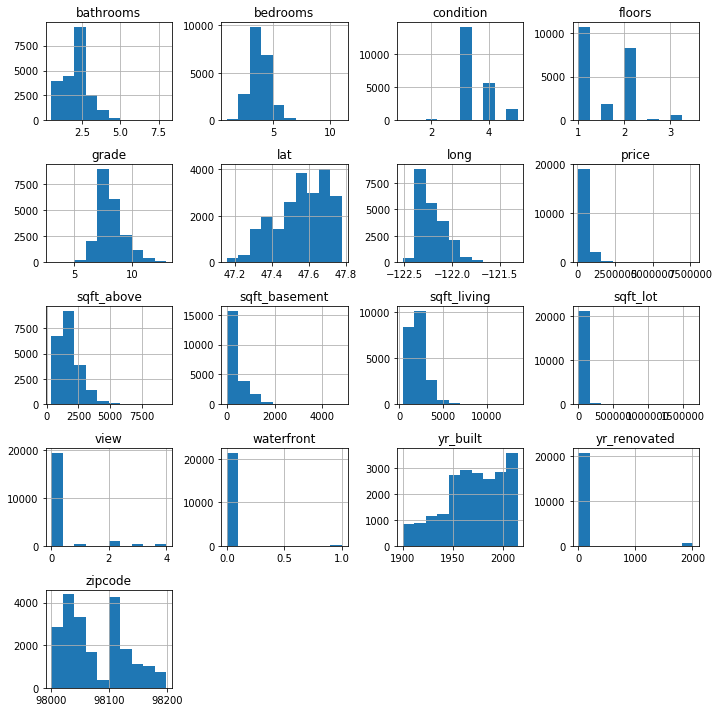

In [65]:
df_renovated.hist(figsize=(10,10))
plt.tight_layout()

## Scatter Matrix

In [66]:
#fig = pd.plotting.scatter_matrix(df_renovated,figsize=(16,16));
#print(type(fig))

## Heatmap

Text(0.5, 1, 'Correlations')

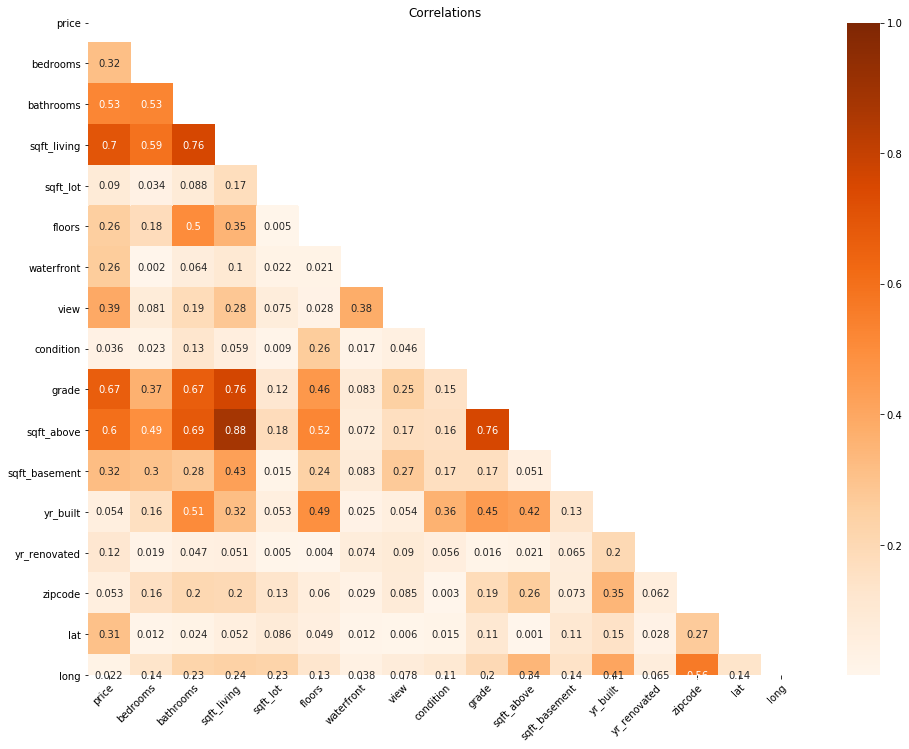

In [67]:
fig, ax = plt.subplots(figsize=(16,12))

corr = df_renovated.corr().abs().round(3)

mask = np.triu(np.ones_like(corr, dtype=np.bool))

sns.heatmap(corr, annot=True, mask=mask, cmap='Oranges', ax=ax)
plt.setp(ax.get_xticklabels(), 
         rotation=45, 
         ha="right",
         rotation_mode="anchor")
ax.set_title('Correlations')

## Scatter Target Variables (better way to do this?)

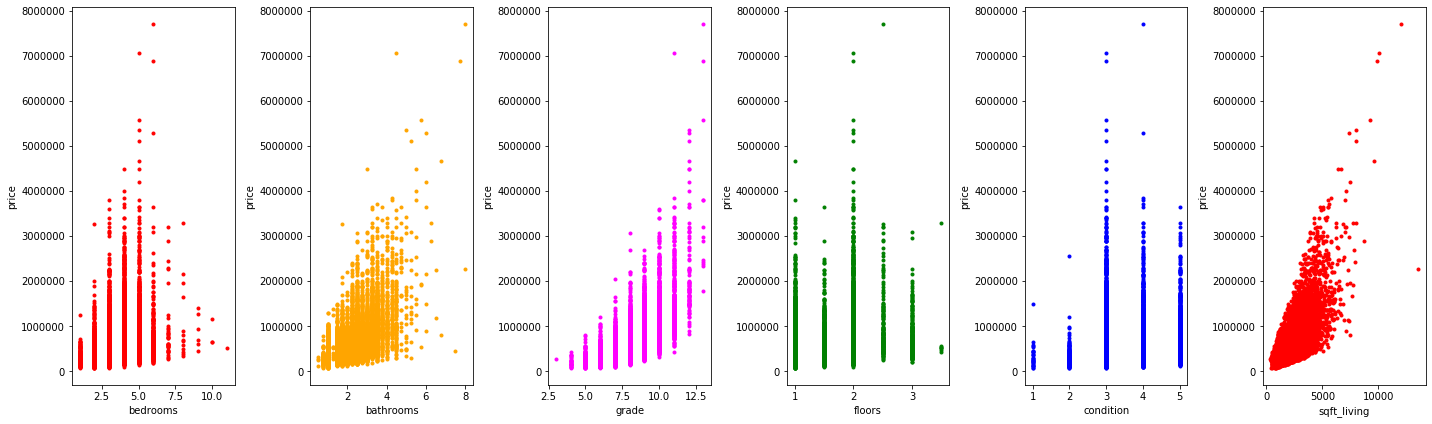

In [68]:
cols_to_plot = ["bedrooms", "bathrooms","grade","floors", "condition", "sqft_living"]

colors = ['red', 'orange', 'magenta', 'green', 'blue','red']
fig, axes = plt.subplots(ncols=6, figsize=(20,6))

for i, col in enumerate(cols_to_plot):
    axes[i].scatter(x=df_renovated[col],y=df_renovated['price'],c=colors[i],marker='.')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('price')
    
plt.tight_layout()

## Plots

### Grade/Price Plot

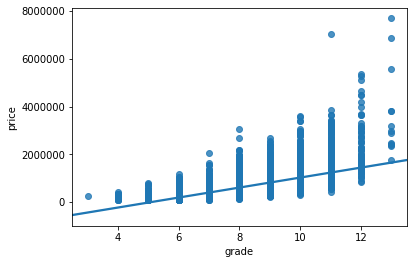

In [69]:
sns.regplot(x= 'grade', y= 'price', data=df_renovated)

### Bedrooms/Price Plot

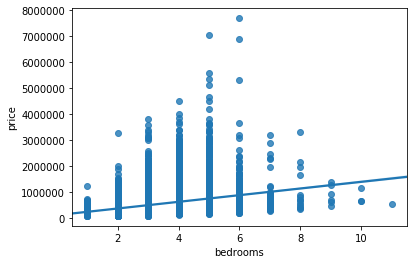

In [70]:
sns.regplot(x= 'bedrooms', y= 'price', data=df_renovated)

### Bathrooms/Price Plot

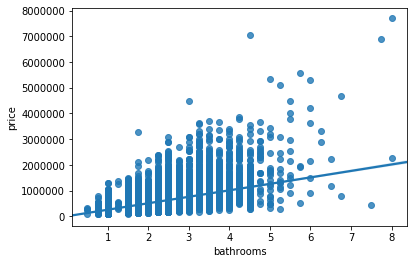

In [71]:
sns.regplot(x= 'bathrooms', y= 'price', data=df_renovated)

### Condition/Price Plot

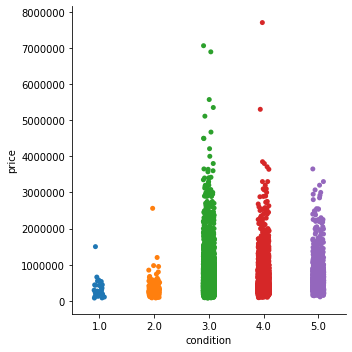

In [72]:
sns.catplot(x= 'condition', y= 'price', data=df_renovated)

### Floors/Price Plot

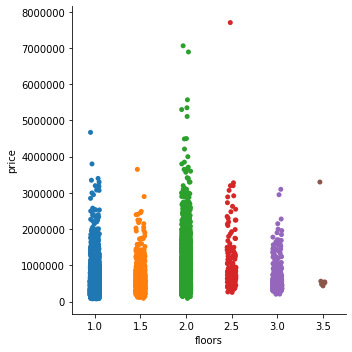

In [73]:
sns.catplot(x= 'floors', y= 'price', data=df_renovated)

### SqFt_Living/Price Plot

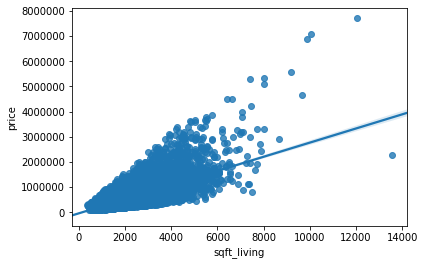

In [74]:
sns.regplot(x= 'sqft_living', y= 'price', data=df_renovated)

### SqFt_Lot/Price Plot

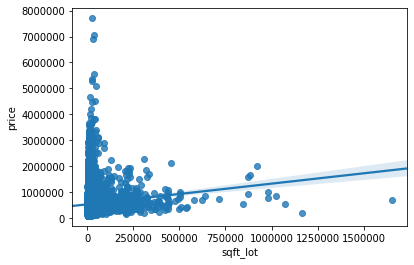

In [75]:
sns.regplot(x= 'sqft_lot', y= 'price', data=df_renovated)

### Waterfront/Price Plot (?)

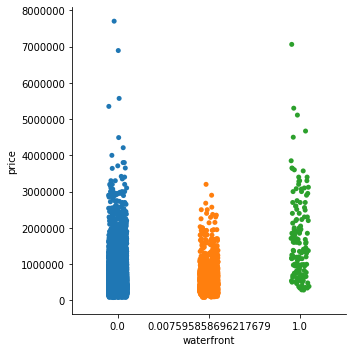

In [76]:
sns.catplot(x= 'waterfront', y= 'price', data=df_renovated)

### View/Price Plot

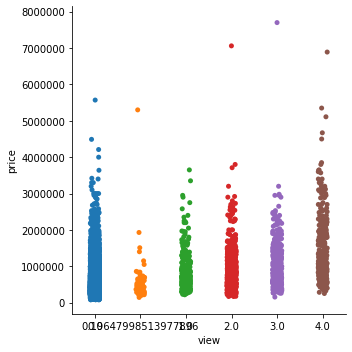

In [77]:
sns.catplot(x= 'view', y= 'price', data=df_renovated)

### SqFt_Above/Price Plot

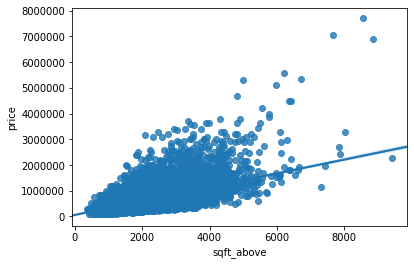

In [78]:
sns.regplot(x= 'sqft_above', y= 'price', data=df_renovated)

### SqFt_Basement/Price Plot (Needs Fixing)

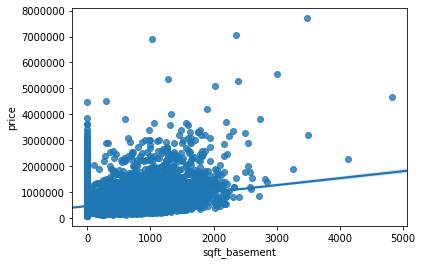

In [79]:
sns.regplot(x= 'sqft_basement', y= 'price', data=df_renovated)

### Lat/Price Plot

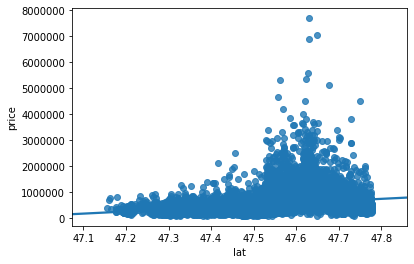

In [80]:
sns.regplot(x= 'lat', y= 'price', data=df_renovated)

### Long/Price Plot

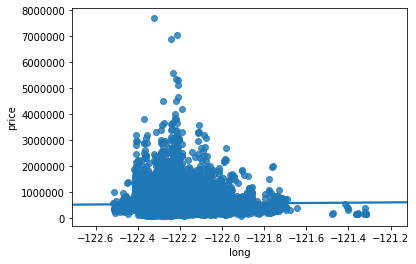

In [81]:
sns.regplot(x= 'long', y= 'price', data=df_renovated)

## Dataframe Info Recheck

In [82]:
df_renovated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 17 columns):
price            21597 non-null float64
bedrooms         21597 non-null int32
bathrooms        21597 non-null float64
sqft_living      21597 non-null int32
sqft_lot         21597 non-null int32
floors           21597 non-null float64
waterfront       21597 non-null float64
view             21597 non-null float64
condition        21597 non-null float64
grade            21597 non-null int32
sqft_above       21597 non-null int32
sqft_basement    21597 non-null float64
yr_built         21597 non-null int32
yr_renovated     21597 non-null int32
zipcode          21597 non-null float64
lat              21597 non-null float64
long             21597 non-null float64
dtypes: float64(10), int32(7)
memory usage: 2.2 MB


# MODEL

## Initial Model on Price

In [85]:
outcome = 'price'
x_cols = ['bedrooms','bathrooms','floors','condition','grade','sqft_living', 'sqft_above','sqft_lot','waterfront','view','sqft_basement','zipcode','lat','long']

In [86]:
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=df_renovated).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.677
Model:                            OLS   Adj. R-squared:                  0.677
Method:                 Least Squares   F-statistic:                     3227.
Date:                Mon, 07 Dec 2020   Prob (F-statistic):               0.00
Time:                        09:05:04   Log-Likelihood:            -2.9520e+05
No. Observations:               21597   AIC:                         5.904e+05
Df Residuals:                   21582   BIC:                         5.905e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -3.042e+07   2.79e+06    -10.888      0.000   -3.59e+07   -2.49e+07
bedrooms       -3.43e+04   2048.691    -16.744      0.000   -3.83e+04   -3.03e+04
bathrooms      4782.2993   3203.170      1.493      0.135   -1496.151    1.11e+04
floors        -2.455e+04   3622.228     -6.777      0.000   -3.16e+04   -1.74e+04
condition      5.074e+04   2305.040     22.011      0.000    4.62e+04    5.53e+04
grade          8.169e+04   2093.679     39.018      0.000    7.76e+04    8.58e+04
sqft_living     133.7551     18.745      7.136      0.000      97.014     170.496
sqft_above       80.5606     18.732      4.301      0.000      43.844     117.277
sqft_lot          0.0051      0.036      0.143      0.887      -0.066       0.076
waterfront     6.193e+05   1.88e+04     32.917      0.000    5.82e+05    6.56e+05
view           6.388e+04   2164.819     29.509      0.000    5.96e+04    6.81e+04
sqft_basement    44.6802     18.586      2.404      0.016       8.251      81.110
zipcode        -445.0530     33.832    -13.155      0.000    -511.366    -378.740
lat            6.804e+05   1.09e+04     62.204      0.000    6.59e+05    7.02e+05
long          -3.366e+05    1.3e+04    -25.836      0.000   -3.62e+05   -3.11e+05
==============================================================================
Omnibus:                    17713.295   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1520527.514
Skew:                           3.411   Prob(JB):                         0.00
Kurtosis:                      43.536   Cond. No.                     1.96e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.96e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Regression Results

In [87]:
model.params.sort_values()

Intercept       -3.042286e+07
long            -3.366387e+05
bedrooms        -3.430262e+04
floors          -2.454612e+04
zipcode         -4.450530e+02
sqft_lot         5.141971e-03
sqft_basement    4.468019e+01
sqft_above       8.056063e+01
sqft_living      1.337551e+02
bathrooms        4.782299e+03
condition        5.073668e+04
view             6.388166e+04
grade            8.169187e+04
waterfront       6.192965e+05
lat              6.804000e+05
dtype: float64

## Initial Trends
- Insert Here

## Refinement

### Normality

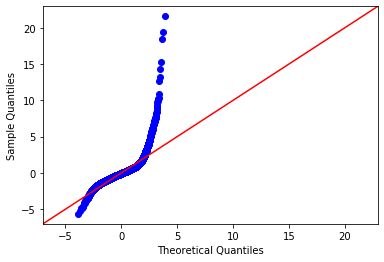

In [88]:
fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)

### Outliers Present
- Check Prices

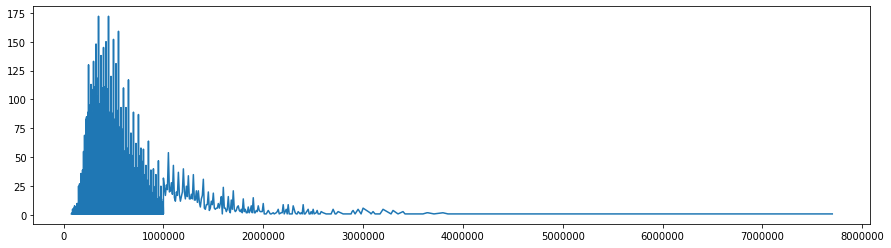

In [89]:
plt.figure(figsize=(15,4))
plt.plot(df_renovated['price'].value_counts().sort_index())

### Filter price - Attempt to Fix Normality
- Try to filter over $1,000,000

In [90]:
for i in range(90,100):
    q = i / 100
    print('{} percentile: {}'.format(q, df_renovated['price'].quantile(q=q)))

0.9 percentile: 887000.0
0.91 percentile: 919993.6
0.92 percentile: 950000.0
0.93 percentile: 997964.0000000002
0.94 percentile: 1060000.0
0.95 percentile: 1160000.0
0.96 percentile: 1260000.0
0.97 percentile: 1390000.0
0.98 percentile: 1600000.0
0.99 percentile: 1970000.0


### Homoscedasticity

In [91]:
#plt.scatter(model.predict([x_cols]), model.resid)
#plt.plot(model.predict([x_cols]), [0 for i in range(len(subset))])

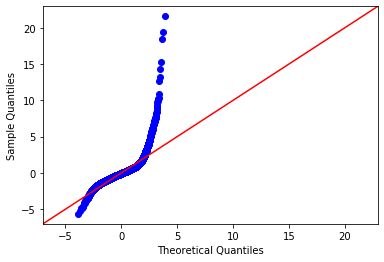

In [92]:
fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)

## Train Split Test

In [93]:
y = df_renovated[['price']]
X = df_renovated.drop(['price'], axis=1)

In [94]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [95]:
print(len(X_train), len(X_test), len(y_train), len(y_test))

17277 4320 17277 4320


In [96]:
print(X_train)

       bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  view  \
664           3       1.00         1290     12231     1.0    0.000000   0.0   
203           3       1.50         1300      7370     1.0    0.000000   0.0   
8190          3       1.75         1540     10800     1.0    0.000000   0.0   
18769         2       1.00          720      4592     1.0    0.000000   0.0   
20429         3       3.00         1571      2017     3.0    0.000000   0.0   
...         ...        ...          ...       ...     ...         ...   ...   
20437         3       2.75         2670      3738     1.0    0.007596   0.0   
1872          3       1.50         1330      6768     1.0    0.007596   0.0   
3238          3       2.75         1650      5700     2.0    0.000000   0.0   
1079          4       2.75         1810      8677     1.5    0.000000   0.0   
12893         4       2.50         1720      3515     2.0    0.000000   2.0   

       condition  grade  sqft_above  sqft_basement 

In [97]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

In [98]:
train_residuals = y_hat_train - y_train
test_residuals = y_hat_test - y_test

In [99]:
mse_train = np.sum((y_train-y_hat_train)**2)/len(y_train)
mse_test = np.sum((y_test-y_hat_test)**2)/len(y_test)
print('Train Mean Squarred Error:', mse_train)
print('Test Mean Squarred Error:', mse_test)

Train Mean Squarred Error: price    4.050244e+10
dtype: float64
Test Mean Squarred Error: price    4.079104e+10
dtype: float64


In [100]:
train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)
print('Train Mean Squarred Error:', train_mse)
print('Test Mean Squarred Error:', test_mse)

Train Mean Squarred Error: 40502437202.71814
Test Mean Squarred Error: 40791039805.58118


In [101]:
linreg.score(X_test, y_test)

0.6841740453851308

### Z - Score

In [102]:
z = np.abs(stats.zscore(df_renovated["price"]))
print(np.where(z > 3))

(array([   21,   153,   246,   269,   282,   300,   312,   518,   540,
         556,   656,   779,   814,  1030,  1150,  1159,  1162,  1215,
        1270,  1280,  1313,  1359,  1418,  1431,  1446,  1674,  1728,
        1730,  1768,  1942,  1943,  2038,  2083,  2134,  2138,  2177,
        2198,  2234,  2265,  2318,  2442,  2459,  2471,  2563,  2624,
        2856,  2862,  2897,  2972,  3018,  3033,  3037,  3089,  3154,
        3226,  3255,  3278,  3335,  3341,  3381,  3515,  3731,  3744,
        3757,  3765,  3773,  3809,  3857,  3867,  3910,  4009,  4028,
        4031,  4145,  4186,  4214,  4264,  4335,  4402,  4404,  4407,
        4424,  4482,  4631,  4758,  4807,  4855,  4917,  4918,  5428,
        5444,  5446,  5584,  5595,  5612,  5697,  5744,  5822,  5824,
        5858,  5874,  5961,  6035,  6039,  6189,  6191,  6227,  6329,
        6396,  6493,  6495,  6502,  6685,  6708,  6734,  6765,  6777,
        6788,  6995,  7028,  7070,  7120,  7184,  7245,  7304,  7306,
        7380,  7408

# Interpret

In [104]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.677
Model:                            OLS   Adj. R-squared:                  0.677
Method:                 Least Squares   F-statistic:                     3227.
Date:                Mon, 07 Dec 2020   Prob (F-statistic):               0.00
Time:                        09:05:59   Log-Likelihood:            -2.9520e+05
No. Observations:               21597   AIC:                         5.904e+05
Df Residuals:                   21582   BIC:                         5.905e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -3.042e+07   2.79e+06    -10.888      0.000   -3.59e+07   -2.49e+07
bedrooms       -3.43e+04   2048.691    -16.744      0.000   -3.83e+04   -3.03e+04
bathrooms      4782.2993   3203.170      1.493      0.135   -1496.151    1.11e+04
floors        -2.455e+04   3622.228     -6.777      0.000   -3.16e+04   -1.74e+04
condition      5.074e+04   2305.040     22.011      0.000    4.62e+04    5.53e+04
grade          8.169e+04   2093.679     39.018      0.000    7.76e+04    8.58e+04
sqft_living     133.7551     18.745      7.136      0.000      97.014     170.496
sqft_above       80.5606     18.732      4.301      0.000      43.844     117.277
sqft_lot          0.0051      0.036      0.143      0.887      -0.066       0.076
waterfront     6.193e+05   1.88e+04     32.917      0.000    5.82e+05    6.56e+05
view           6.388e+04   2164.819     29.509      0.000    5.96e+04    6.81e+04
sqft_basement    44.6802     18.586      2.404      0.016       8.251      81.110
zipcode        -445.0530     33.832    -13.155      0.000    -511.366    -378.740
lat            6.804e+05   1.09e+04     62.204      0.000    6.59e+05    7.02e+05
long          -3.366e+05    1.3e+04    -25.836      0.000   -3.62e+05   -3.11e+05
==============================================================================
Omnibus:                    17713.295   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1520527.514
Skew:                           3.411   Prob(JB):                         0.00
Kurtosis:                      43.536   Cond. No.                     1.96e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.96e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [105]:
pd.set_option('display.max_rows', None)

In [106]:
df_renovated = df_renovated.sort_values('coef', ascending=False)
df_renovated.head(15)

KeyError: 'coef'

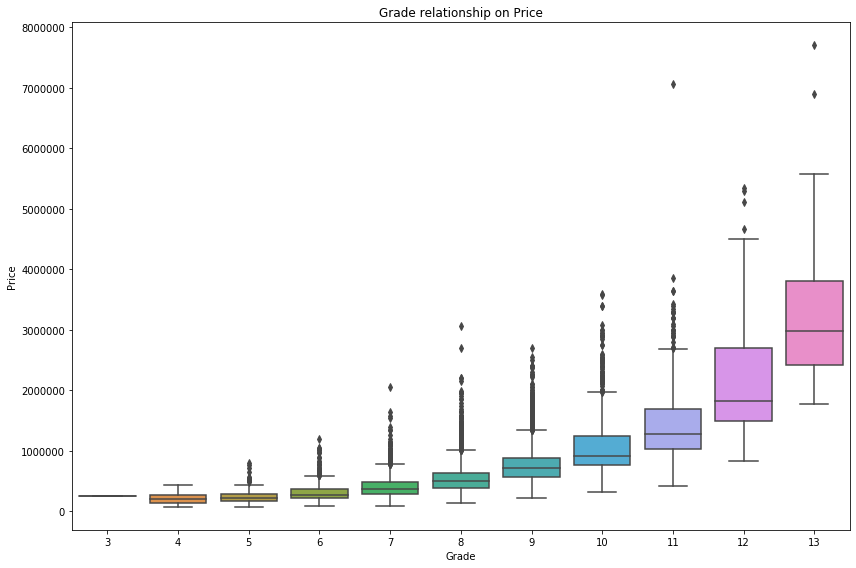

In [107]:
fig, ax = plt.subplots(figsize=(12,8))

sns.boxplot(x='grade', y='price', data=df_renovated)
ax.set(title='Grade relationship on Price', 
       xlabel='Grade', ylabel='Price')

fig.tight_layout()

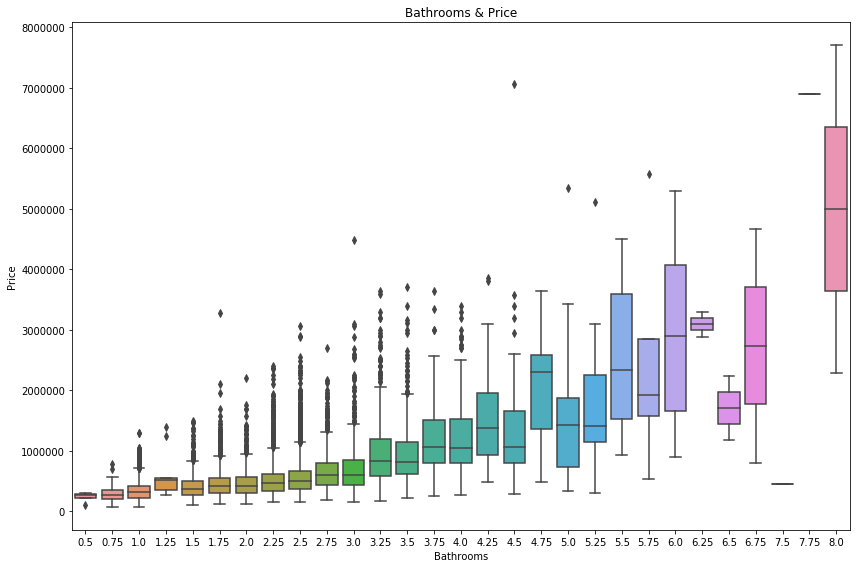

In [108]:
fig, ax = plt.subplots(figsize=(12,8))

sns.boxplot(x='bathrooms', y='price', data=df_renovated)
ax.set(title='Bathrooms & Price', 
       xlabel='Bathrooms', ylabel='Price')

fig.tight_layout()

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))

sns.boxplot(x='bedrooms', y='price', data=df_renovated)
ax.set(title='Bedrooms & Price', 
       xlabel='Bedrooms', ylabel='Price')

fig.tight_layout()

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))

sns.boxplot(x='floors', y='price', data=df_renovated)
ax.set(title='Floors & Price', 
       xlabel='Floors', ylabel='Price')

fig.tight_layout()

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))

sns.boxplot(x='condition', y='price', data=df_renovated)
ax.set(title='Condition & Price', 
       xlabel='Condition', ylabel='Price')

fig.tight_layout()

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))

sns.regplot(x='sqft_living', y='price', data=df_renovated)
ax.set(title='Square Feet Living Space & Price', 
       xlabel='SqFt.', ylabel='Price')

fig.tight_layout()

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))

sns.regplot(x='sqft_above', y='price', data=df_renovated)
ax.set(title='Square Feet Above & Price', 
       xlabel='Sqft. Above', ylabel='Price')

fig.tight_layout()

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))

sns.boxplot(x='yr_built', y='price', data=df_renovated)
ax.set(title='Year Built & Price', 
       xlabel='Year Built', ylabel='Price')

fig.tight_layout()

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))

sns.boxplot(x='yr_renovated', y='price', data=df_renovated)
ax.set(title='Year Renovated & Price', 
       xlabel='Year', ylabel='Price')

fig.tight_layout()

In [ ]:
df_renovated=data_pred.corr().abs().stack().reset_index().sort_values(0, ascending=False)
df_renovated['pairs'] = list(zip(df_renovated.level_0,df_renovated.level_1)
df_renovated.set_index(['pairs'], inplace = True)
df_renovated.drop(columns=['level_1','level_0'], inplace = True)
df_renovated.columns = ['cc']
df.drop_ducplicates(inplace=True)

In [ ]:
df_renovated[(df.cc>.75) & (df.cc <1)]

# Conclusions & Recommendations